In [1]:
from datasets import load_dataset
from setfit import sample_dataset

# Load a dataset from the Hugging Face Hub
dataset = load_dataset("ag_news")

# Create a sample few-shot dataset to train with
train_dataset = sample_dataset(dataset["train"], label_column="label", num_samples=16)
# Dataset({
#     features: ['text', 'label'],
#     num_rows: 64
# })

# Dataset for evaluation
eval_dataset = dataset["test"]
# Dataset({
#     features: ['text', 'label'],
#     num_rows: 7600
# })

/root/miniconda/envs/rblu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the latest cached version of the dataset since ag_news couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/ag_news/default/0.0.0/eb185aade064a813bc0b7f42de02595523103ca4 (last modified on Thu Feb 13 13:52:10 2025).


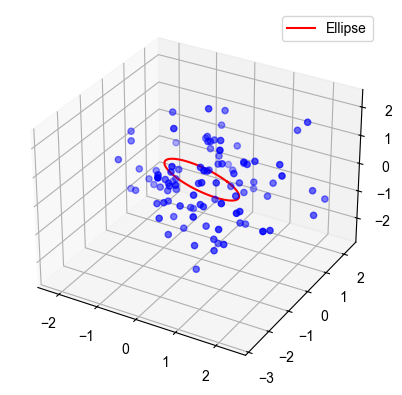

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 生成随机数据
np.random.seed(0)
n_points = 100
X = np.random.randn(n_points, 3)

# 计算数据的均值和协方差矩阵
mean = np.mean(X, axis=0)
cov = np.cov(X.T)

# 计算协方差矩阵的特征值和特征向量
eigenvalues, eigenvectors = np.linalg.eig(cov)

# 确定椭圆的半径（特征值的平方根表示每个轴的扩展程度）
radii = np.sqrt(eigenvalues)

# 生成椭圆的角度（在主成分空间上）
theta = np.linspace(0, 2 * np.pi, 100)

# 用于生成椭圆点的矩阵
ellipse_points = np.array([radii[0] * np.cos(theta), radii[1] * np.sin(theta), np.zeros_like(theta)])

# 旋转椭圆到数据的实际空间
rotated_ellipse = np.dot(eigenvectors, ellipse_points)

# 3D绘图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制散点
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='b', marker='o')

# 添加椭圆
ax.plot(rotated_ellipse[0, :], rotated_ellipse[1, :], rotated_ellipse[2, :], c='r', label='Ellipse')

# 添加图例
ax.legend()

# 显示图形
plt.show()


In [3]:
from setfit import SetFitModel, TrainingArguments, Trainer
import os
# Set proxy
os.environ['http_proxy'] = 'http://172.17.0.1:10810'
os.environ['https_proxy'] = 'http://172.17.0.1:10810'
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L3-v2")

args = TrainingArguments(
    batch_size=64,
    num_epochs=5,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)
trainer.train()

metrics = trainer.evaluate()
print(metrics)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Currently using DataParallel (DP) for multi-gpu training, while DistributedDataParallel (DDP) is recommended for faster training. See https://sbert.net/docs/sentence_transformer/training/distributed.html for more information.
/root/miniconda/envs/rblu/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
Map: 100%|██████████| 64/64 [00:00<00:00, 9688.01 examples/s]
***** Running training *****
  Num unique pairs = 3072
  Batch size = 64
  Num epochs = 5
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 534602988. Use `wandb login --relogin` to force relogin
/root/miniconda/envs/rbl

Step,Training Loss
1,0.358300
50,0.240100
100,0.138400


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]/root/miniconda/envs/rblu/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
***** Running evaluation *****                                       
/root/miniconda/envs/rblu/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


{'accuracy': 0.8236842105263158}


/root/miniconda/envs/rblu/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


In [4]:
# Create a dataset of unlabeled examples to perform knowledge distillation
unlabeled_train_dataset = dataset["train"].shuffle(seed=0).select(range(500))
unlabeled_train_dataset = unlabeled_train_dataset.remove_columns("label")
# Dataset({
#     features: ['text'],
#     num_rows: 500
# })

In [5]:
from setfit import SetFitModel

teacher_model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [6]:
from setfit import TrainingArguments, Trainer

teacher_args = TrainingArguments(
    batch_size=16,
    num_epochs=2,
)

teacher_trainer = Trainer(
    model=teacher_model,
    args=teacher_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Train teacher model
teacher_trainer.train()
teacher_metrics = teacher_trainer.evaluate()
print(teacher_metrics)

Currently using DataParallel (DP) for multi-gpu training, while DistributedDataParallel (DDP) is recommended for faster training. See https://sbert.net/docs/sentence_transformer/training/distributed.html for more information.
/root/miniconda/envs/rblu/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/root/miniconda/envs/rblu/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/root/miniconda/envs/rblu/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future ver

Step,Training Loss
1,0.408500
50,0.159800
100,0.004400
150,0.000500


***** Running evaluation *****                                       
/root/miniconda/envs/rblu/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


{'accuracy': 0.8610526315789474}


/root/miniconda/envs/rblu/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


In [ ]:
from setfit import DistillationTrainer

distillation_args = TrainingArguments(
    batch_size=16,
    max_steps=500,
)

distillation_trainer = DistillationTrainer(
    teacher_model=teacher_model,
    student_model=model,
    args=distillation_args,
    train_dataset=unlabeled_train_dataset,
    eval_dataset=eval_dataset,
)
# Train student with knowledge distillation
distillation_trainer.train()
distillation_metrics = distillation_trainer.evaluate()
print(distillation_metrics)

Currently using DataParallel (DP) for multi-gpu training, while DistributedDataParallel (DDP) is recommended for faster training. See https://sbert.net/docs/sentence_transformer/training/distributed.html for more information.
/root/miniconda/envs/rblu/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/root/miniconda/envs/rblu/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
/root/miniconda/envs/rblu/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future ver

Step,Training Loss
1,0.537500
50,0.281500
100,0.005500
150,0.001600
200,0.001100
250,0.000800
300,0.000600
350,0.000600
400,0.000500
450,0.000500


***** Running evaluation *****
/root/miniconda/envs/rblu/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


{'accuracy': 0.8359210526315789}


/root/miniconda/envs/rblu/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
